# kaggle Study 42일차(Toxic)
코드출처 : https://www.kaggle.com/sbongo/for-beginners-tackling-toxic-using-keras

이 노트북은 Keras LSTM을 사용하여 이 분류 문제를 해결하려고 합니다. 이미 이 접근 방식을 사용하여 작업하고 있는 노트북이 많지만, 각 단계마다 어떤 작업이 진행되고 있는지 충분히 설명하지 못하고 있다고 생각합니다. 바닐라 텐서플로우를 사용하고 있고, 최근 케라스의 멋진 세계를 받아들인 사람으로서, 저는 제 연구와 연구를 통해 얻은 직감을 동료 초보자들과 공유하고 싶습니다.

함께 걸어가자고요.

우리는 표준 케라스 라이브러리를 수입합니다.

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [2]:
train = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/toxic/train.csv')
test = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/toxic/test.csv')

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


일반적인 사전 처리 단계는 다음 단계로 진행하기 전에 null을 확인하고 null 값을 무언가로 채우는 것입니다. null 값을 그대로 두면 나중에 모델링 단계에서 트립업됩니다.

In [4]:
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool,
 id              False
 comment_text    False
 dtype: bool)

결국 우리는 무효값을 처리할 필요가 없어 보이는군요!

참고: 데이터 세트에 대해 수행할 수 있는 수많은 사전 처리 및 기능 엔지니어링 단계가 있습니다. 하지만 오늘날에는 사전 처리 작업에 초점을 맞추지 않기 때문에 나머지 단계가 제대로 작동될 수 있는 최소한의 작업이 중요합니다.

다음으로 넘어가면, 여러분이 몰래 보는 것처럼, 종속 변수들은 훈련 세트 자체에 있기 때문에 우리는 그것들을 X와 Y 세트로 나누어야 합니다.

In [5]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

우리가 취하고 있는 접근 방식은 신경망의 일부로 LSTM에 의견을 전달하는 것이지만, 우리는 그대로 단어를 전달할 수 없습니다.

이것이 바로 우리가 할 일입니다.

1. 토큰화 - 우리는 문장을 독특한 단어로 나눌 필요가 있습니다. 예를 들어, "나는 고양이를 사랑하고 개를 사랑합니다"는 [I,"love,"cats,"그리고 "dogs]가 될 것입니다.
2. 색인화 - 단어들을 사전과 같은 구조로 배치하고 각각의 색인을 제공합니다. 예, {1:"I",2:"love",3:"cats",4:"그리고",5:"dogs"}
3. 색인 표현 - 주석의 단어 순서를 색인 형식으로 나타낼 수 있으며, 이 색인 체인을 LSTM에 제공할 수 있습니다. 예: [1,2,3,4,2,5]입니다.  
  
다행스럽게도 케라스는 우리의 삶을 훨씬 더 쉽게 만들었습니다. 바닐라 텐서플로우를 사용하는 경우, 자신만의 사전 구조를 구현하고 색인을 직접 처리해야 할 수도 있습니다. Keras에서는 위의 모든 단계를 4줄의 코드로 수행할 수 있습니다. 문장을 토큰화할 때 사전에 고유 단어 수를 정의해야 합니다.

In [6]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

사전에서 각 단어의 발생 및 색인을 찾아볼 수도 있습니다.

In [7]:
#사용하고 싶다면 주석 해제하면 됨.
#for occurence of words
#tokenizer.word_counts
#for index of words
#tokenizer.word_index

이제 "list_tokenized_train"을 보시면 Keras가 우리의 말을 색인 표현으로 바꾼 것을 보실 수 있을 것입니다.

In [8]:
list_tokenized_train[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

하지만 여전히 한 가지 문제가 있습니다! 어떤 댓글은 엄청 긴데, 어떤 댓글은 딱 한 단어면 어떡해요? 우리의 색인화된 문장은 다음과 같지 않을까요?

Comment #1: [8,9,3,7,6,3,6,6,2,3,4,9]

Comment #2: [1,2]

또한 일관된 길이(고정 수의 기능)를 가진 데이터 스트림을 제공해야 합니다. 그렇지 않습니까?

그리고 이것이 우리가 "패딩"을 사용하는 이유입니다! 우리는 부족한 부분을 0으로 채워 다른 문장들처럼 짧은 문장을 만들 수 있었습니다.하지만 반면에, 우리는 긴 것을 짧은 것과 같은 길이(최대)로 잘라야 합니다. 이 경우 최대 길이는 200으로 설정했습니다.

In [9]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

설정하기에 가장 좋은 "maxlen"이 무엇인지 어떻게 알 수 있습니까? 너무 짧게 말하면 경로상 일부 정확도가 저하될 수 있는 몇 가지 유용한 기능이 손실될 수 있습니다.너무 오래 두면 LSTM 셀이 더 커야 가능한 값 또는 상태를 저장할 수 있습니다.

이 문제를 해결하는 방법 중 하나는 문장에서 단어 수의 분포를 보는 것입니다.

In [10]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

(array([21439., 27127., 22176., 16223., 12859., 10062.,  7586.,  5991.,
         4731.,  3914.,  3129.,  2820.,  2306.,  1896.,  1647.,  1455.,
         1329.,  1287.,  1013.,   857.,   750.,   799.,   528.,   581.,
          486.,   437.,   407.,   373.,   386.,   292.,   284.,   242.,
          217.,   169.,   156.,   167.,   158.,   133.,   136.,   116.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
        390, 400]),
 <BarContainer object of 40 artists>)

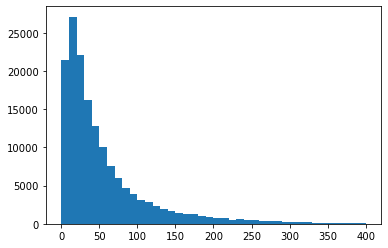

In [11]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))

우리가 볼 수 있듯이, 대부분의 문장 길이는 약 30+입니다. "maxlen"을 약 50으로 설정할 수 있지만, 저는 편집증적이어서 200으로 설정했습니다. 한편, 이것은 여러분이 실험할 수 있는 것으로 들리고 마법의 숫자가 무엇인지 볼 수 있습니다.

드디어 모델 제작의 시작입니다!
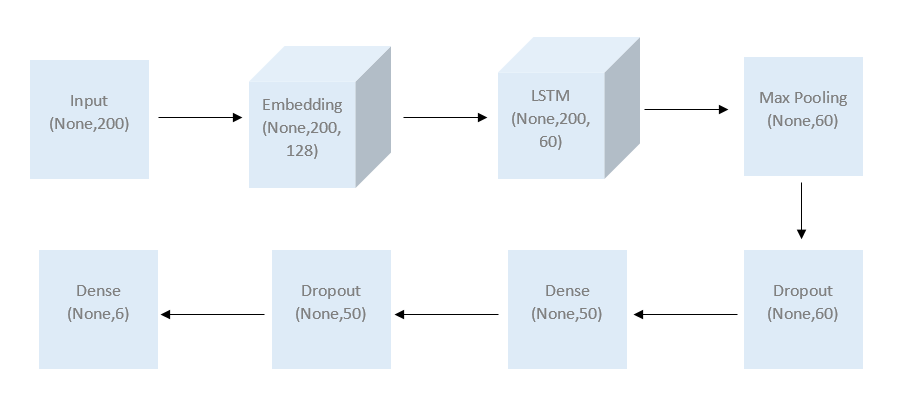
이것이 우리가 만들려고 하는 모델의 구조입니다. 항상 모델의 각 레이어 크기를 나열하여 시각적으로 생각하고 나중에 디버깅할 수 있도록 돕는 것이 좋습니다.
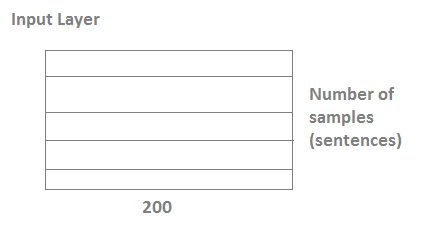
앞에서 언급했듯이, 네트워크 입력은 인코딩된 문장의 목록입니다. 우리는 차원이 200인 문장 목록을 받아들이는 입력 계층을 정의하기 시작합니다.쉼표 뒤에 빈 칸을 표시하여 Keras에게 숫자를 자동으로 추론하도록 지시합니다.

In [12]:
inp = Input(shape=(maxlen, ))

다음으로, 우리는 그것을 우리의 임베딩 레이어로 전달하며, 우리는 문장에서 주변 단어의 거리에 따라 정의된 벡터 공간에 단어를 투영합니다. 임베딩을 사용하면 모델 크기를 줄일 수 있으며, 가장 중요한 것은 문장의 단어를 표현하기 위해 원핫 인코딩을 사용하는 경우 처리해야 하는 엄청난 차원을 줄일 수 있습니다.Embedding 레이어의 출력은 이 벡터 공간에 있는 단어의 좌표 목록일 뿐입니다. 예를 들어 "고양이"의 경우(-81.012)이고 "개"의 경우(-80.012)입니다. 또한 이러한 좌표의 거리를 사용하여 관련성과 맥락을 감지할 수 있습니다. 임베딩은 상당히 심층적인 주제이며, 관심이 있으시다면 포괄적인 가이드입니다. https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/

위에서 언급한 "벡터 공간"의 크기와 우리가 사용하고 있는 고유 단어(max_features)의 수를 정의해야 합니다. 다시, 임베딩 크기는 조정 및 실험할 수 있는 매개 변수입니다.

In [14]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

임베딩 계층은 (없음, 200, 128)의 3-D 텐서를 출력합니다. 이는 문장 배열이며, 각 단어(200)에 대해 128개의 좌표 배열이 임베딩의 벡터 공간에 있습니다.

다음으로, 우리는 이 텐서를 LSTM 계층에 공급합니다. LSTM을 60의 차원을 가진 출력을 생성하도록 설정하고 전체 미롤링된 결과 시퀀스를 반환하도록 합니다. 아시다시피 LSTM 또는 RNN은 이전 네트워크의 출력을 현재 네트워크의 입력으로 재귀적으로 공급하여 작동하며, X번의 재귀 후에 최종 출력을 취합니다. 그러나 사용 사례에 따라 롤링되지 않은 또는 각 재귀의 출력을 결과로 가져와 다음 계층으로 전달할 수 있습니다. 그리고 이것이 사실입니다.

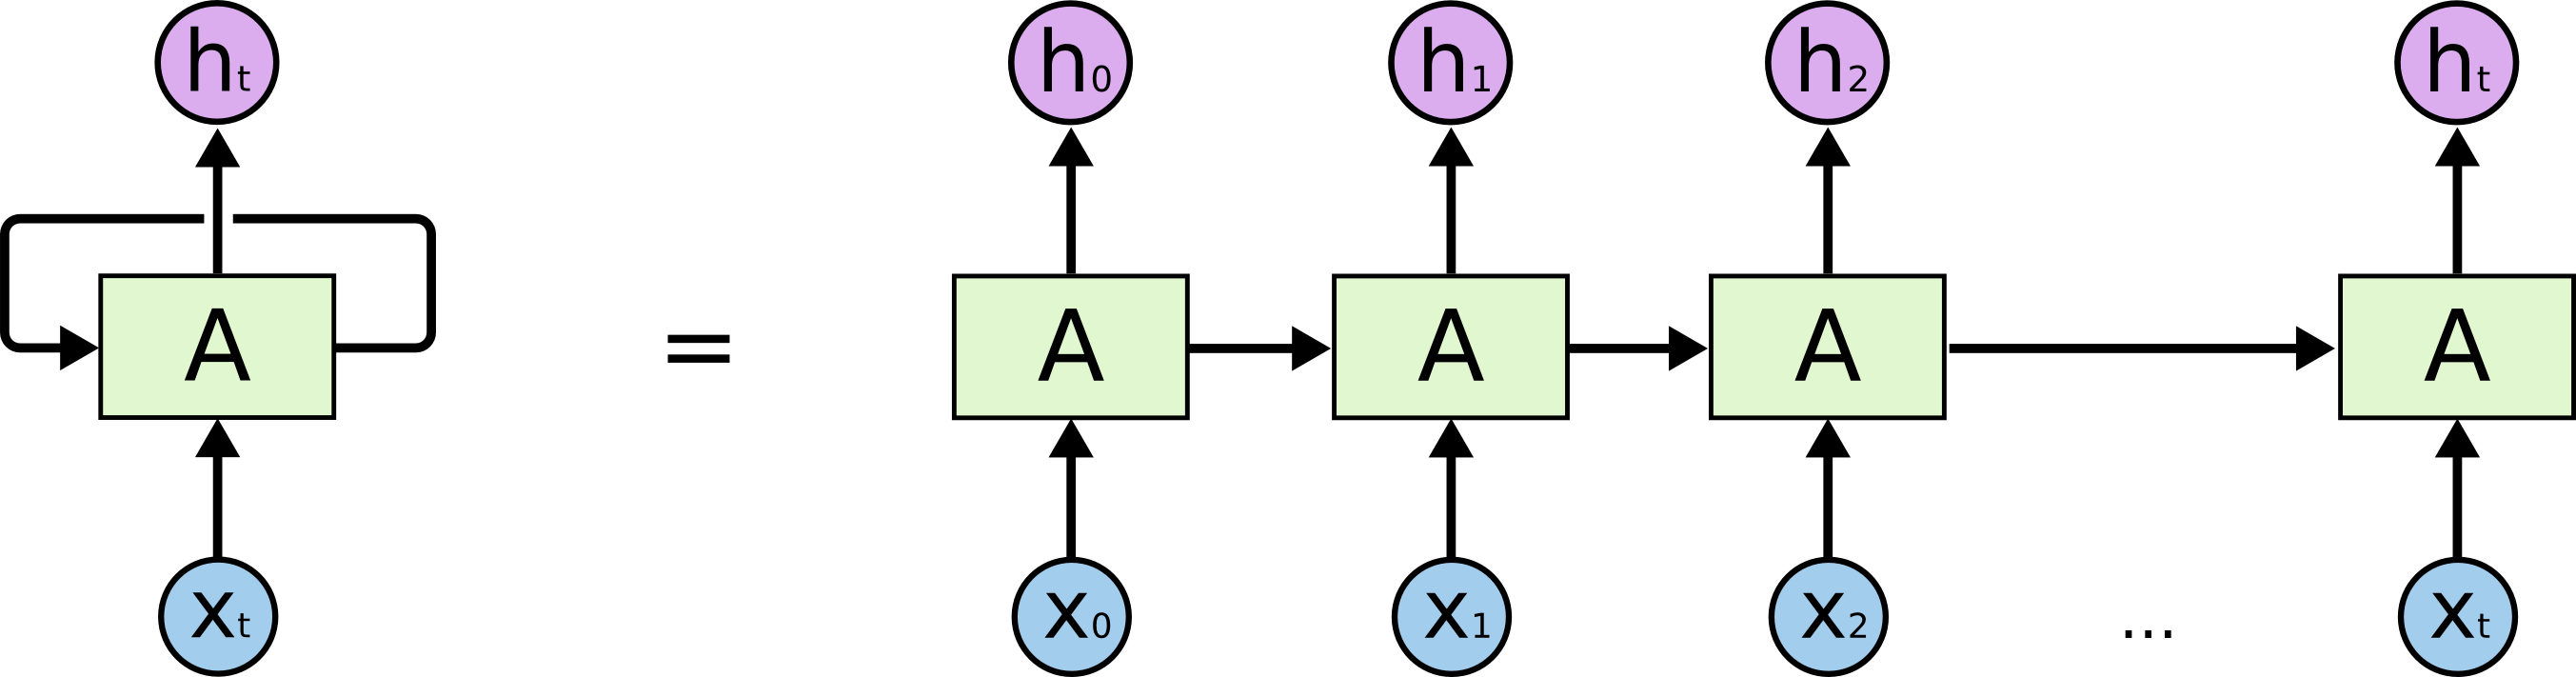

위 그림에서 볼 수 있는 Unrolled LSTM은 마지막까지 h0,h1,h2 세트를 제공합니다.

LSTM 계층을 정의하는 짧은 코드 라인에서 필요한 입력 차원을 놓치기 쉽습니다. LSTM은 배치 크기, 시간 단계, 입력 수의 텐서를 사용합니다. 배치 크기는 배치에 있는 샘플 수이고, 시간 단계는 각 입력에 대해 실행되는 재귀 수이며, 위 그림의 "A" 수로 그려질 수 있습니다. 마지막으로, 입력 수는 위의 "x"에 나온 것처럼 LSTM에 전달하는 변수의 수(각 문장의 단어 수)입니다.

LSTM 계층으로 (None, 200, 128)의 3-D 텐서를 출력하는 이전 임베딩 계층의 출력을 사용할 수 있습니다. 이 방법은 샘플을 통해 LSTM 모델을 200번 반복 실행하고 매번 단어의 좌표를 전달합니다. 그리고 우리는 unrolled 버전을 원하기 때문에 (None, 200, 60)의 텐서 모양을 받게 될 것입니다. 여기서 60은 우리가 정의한 출력 차원입니다.

In [15]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

NotImplementedError: Cannot convert a symbolic Tensor (lstm_layer/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

출력을 일반 레이어로 전달하기 전에 3D 텐서를 2D 텐서로 다시 만들어야 합니다. 우리는 우리에게 중요한 데이터를 버리지 않도록 조심스럽게 모양을 바꾸며, 이상적으로는 결과 데이터가 원본 데이터를 잘 나타내기를 원합니다.

따라서, 우리는 이미지 데이터의 차원을 줄이기 위해 전통적으로 CNN 문제에 사용되는 Global Max Pooling 계층을 사용합니다. 간단히 말해서, 우리는 각 데이터 패치를 검토하고 각 패치의 최대값을 취합니다. 이 최대값 집합은 사용할 수 있는 새로운 크기의 데이터 집합이 될 것입니다.

다른 Kaggle 커널에서 볼 수 있듯이, 풀링 계층의 다른 변형(평균, 최대 등)이 차원 감소에 사용되므로 다른 결과를 얻을 수 있으므로 사용해 보십시오.

풀링에 대한 기술 세부 정보를 알고 싶으시다면, https://wiseodd.github.io/techblog/2016/07/18/convnet-maxpool-layer/를 읽어보십시오.

In [16]:
x = GlobalMaxPool1D()(x)

2D 텐서를 손에 쥐고, 우리는 다음 계층의 노드가 누락된 데이터의 표현을 처리하도록 강요받고 전체 네트워크가 더 나은 일반화를 가져올 수 있도록 일부 노드를 무차별적으로 "비활성화"하는 드롭아웃 계층에 그것을 전달합니다.

우리는 드롭아웃 계층을 노드의 10%(0.1)를 드롭아웃으로 설정합니다.

In [17]:
x = Dropout(0.1)(x)

드롭아웃 레이어 후, 우리는 드롭아웃 레이어의 출력을 촘촘히 연결된 레이어에 연결하고 출력은 RELU 함수를 통과합니다. 간단히 말해 다음과 같습니다.

활성화(입력 X 가중치) + 치우침)

모두 1줄로, 가중치, 치우침 및 활성화 레이어를 모두 설정합니다! 우리는 50의 출력 차원을 만들기 위해 Dense 레이어를 정의했습니다.

In [18]:
x = Dense(50, activation="relu")(x)

출력을 다시 드롭아웃 레이어로 공급합니다.

In [19]:
x = Dropout(0.1)(x)

마지막으로 출력물을 시그모이드 층으로 공급합니다. 시그모이드가 사용되는 이유는 6개의 레이블 각각에 대해 이진 분류(1,0)를 달성하려고 하기 때문에 시그모이드 함수는 0과 1의 경계 사이에서 출력을 스쿼시합니다.

In [20]:
x = Dense(6, activation="sigmoid")(x)

거의 다 됐어요! 이제 입력, 출력 및 학습 프로세스를 정의하는 일만 남았습니다. 우리는 2진수 분류를 다루기 때문에 아담 최적화 도구를 사용하여 손실 함수를 최적화하고 손실 함수를 "이진_교차 엔트로피"로 정의하도록 모델을 설정했습니다. 학습 속도를 찾는 경우 기본값은 0.001로 설정됩니다.

In [21]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

우리가 기다리던 그 순간이 도착했어요! 드디어 우리 모델을 시험해 볼 시간이 왔어요. 각 배치에 대해 32개의 패딩된 색인화된 문장 목록을 제공하고 데이터의 10%를 검증 세트로 분할합니다. 이 검증 집합은 각 배치에 대해 모형이 과대 적합되었는지 여부를 평가하는 데 사용됩니다. 모델은 또한 2ephs 동안 실행됩니다. 다음은 기계를 손상시키지 않고 정확한 수준을 다음 수준으로 끌어올 수 있는지(따라서 배치 크기) 확인하기 위해 실험할 수 있는 조정 가능한 매개 변수 중 일부입니다.

In [22]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 247s 55ms/step - loss: 0.1231 - accuracy: 0.8006 - val_loss: 0.0539 - val_accuracy: 0.9940
Epoch 2/2
4488/4488 [==============================] - 233s 52ms/step - loss: 0.0497 - accuracy: 0.9925 - val_loss: 0.0503 - val_accuracy: 0.9940


기본적인 시도치고는 정확도가 꽤 괜찮은 것 같아요! 정확성을 더욱 높이기 위해 여러분이 할 수 있는 일은 많이 있습니다(아래의 TODO 참조). 그러니 마음껏 커널을 포크로 만들고 직접 실험해 보십시오!

__추가 팁 및 요령__

1) 특히 치수 관련 오류를 반환하기 시작할 때 일부 장애물에 부딪혔다면 "모델"을 실행하는 것이 좋습니다.summary()은(는) 모든 레이어 출력을 나열하기 때문에 진단에 매우 유용합니다.

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 128)          2560000   
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                6450      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306   

2) 레이어를 추가하고 화려한 변환을 수행하는 동안, 예상한 대로 출력이 작동하는지 확인하는 것이 좋습니다. 다음을 통해 특정 계층의 출력을 표시할 수 있습니다.

In [24]:
from keras import backend as K

# with a Sequential model
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].output])
layer_output = get_3rd_layer_output([X_t[:1]])[0]
layer_output.shape
#print layer_output to see the actual data

(1, 128)

개인적으로 저는 케라스가 많은 시간을 줄이고 행렬의 적절한 치수를 정의하는 불쾌한 일을 처리하는 것에 대한 고통을 덜어준다는 것을 알게 되었습니다. 절약된 시간은 다양한 모델 변형 실험 등과 같은 유익한 작업에 소비될 수 있었습니다. 하지만, 저는 많은 변수와 프로세스가 딥 러닝 초보자들이 후드에서 무슨 일이 일어나고 있는지 깨닫지 못할 수 있는 방식으로 자동으로 초기화되었다는 것을 알게 되었습니다. 복잡한 세부 사항들이 많이 있기 때문에 저는 신입사원들에게 이 블랙박스를 열어보라고 권합니다. 그러면 여러분은 딥러닝에 대한 풍부한 지식을 얻게 될 것입니다.

누군가가 이 짧은 가이드가 유용하다고 생각했으면 좋겠어요. 이러한 가이드를 더 많이 보려면 이 커널에 투표하여 저를 지원하십시오. 읽어주셔서 감사하고 대회 운을 빕니다!

작업관리:

- 사전 훈련된 모델을 사용하여 정확도를 높이고 기존 노력을 활용합니다.  
- 벨과 휘파람의 하이퍼 파라미터 튜닝입니다.  
- 모델 교육 중 조기 정지를 소개합니다.  
- 다른 아키텍처로 실험합니다.  